In [135]:
import os
import glob
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from os import listdir, makedirs, getcwd, remove
from os import path
from pathlib import Path
from skimage.io import imread
from skimage.transform import resize
import keras
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, Dropout
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from keras.metrics import Precision, Recall
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix
import imgaug.augmenters as iaa
import cv2


%matplotlib inline

print(os.listdir())

['.git', '.ipynb_checkpoints', 'chest_xray', 'final_project.ipynb', 'README.md']


In [2]:
data_dir = Path('chest_xray')

In [3]:
train_dir = data_dir / 'train'
val_dir = data_dir / 'val'
test_dir = data_dir / 'test'

In [4]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')


train_data = []

# Normal cases - label: 0
for img in normal_cases:
    train_data.append((img,0))

# Normal cases - label: 1
for img in pneumonia_cases:
    train_data.append((img, 1))

train_data = pd.DataFrame(
    train_data, 
    columns = ['image', 'label'],
    index = None
)

# Shuffle 
train_data = train_data.sample(frac=1.).reset_index(drop=True)

train_data.head()

,image,label
0,chest_xray\train\NORMAL\IM-0508-0001.jpeg,0
1,chest_xray\train\PNEUMONIA\person1353_virus_23...,1
2,chest_xray\train\PNEUMONIA\person1240_bacteria...,1
3,chest_xray\train\PNEUMONIA\person663_bacteria_...,1
4,chest_xray\train\PNEUMONIA\person1411_bacteria...,1


1    3875
0    1341
Name: label, dtype: int64


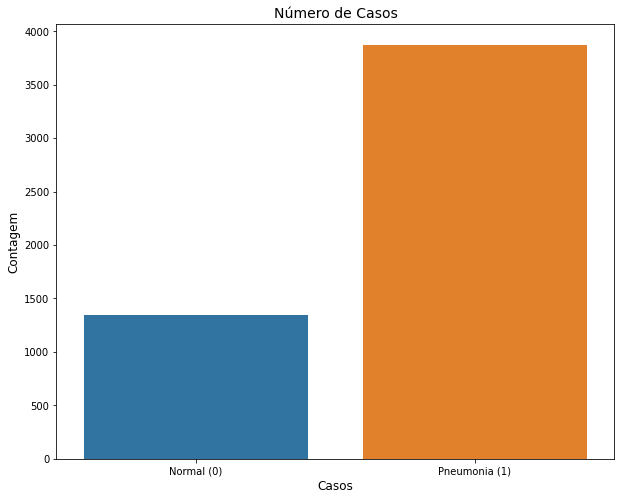

In [11]:
cases_count = train_data['label'].value_counts()
print(cases_count)

plt.figure(figsize = (10,8))
sns.barplot(x = cases_count.index, y = cases_count.values)
plt.title('Número de Casos', fontsize=14)
plt.xlabel('Casos', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal (0)', 'Pneumonia (1)'])
plt.show()

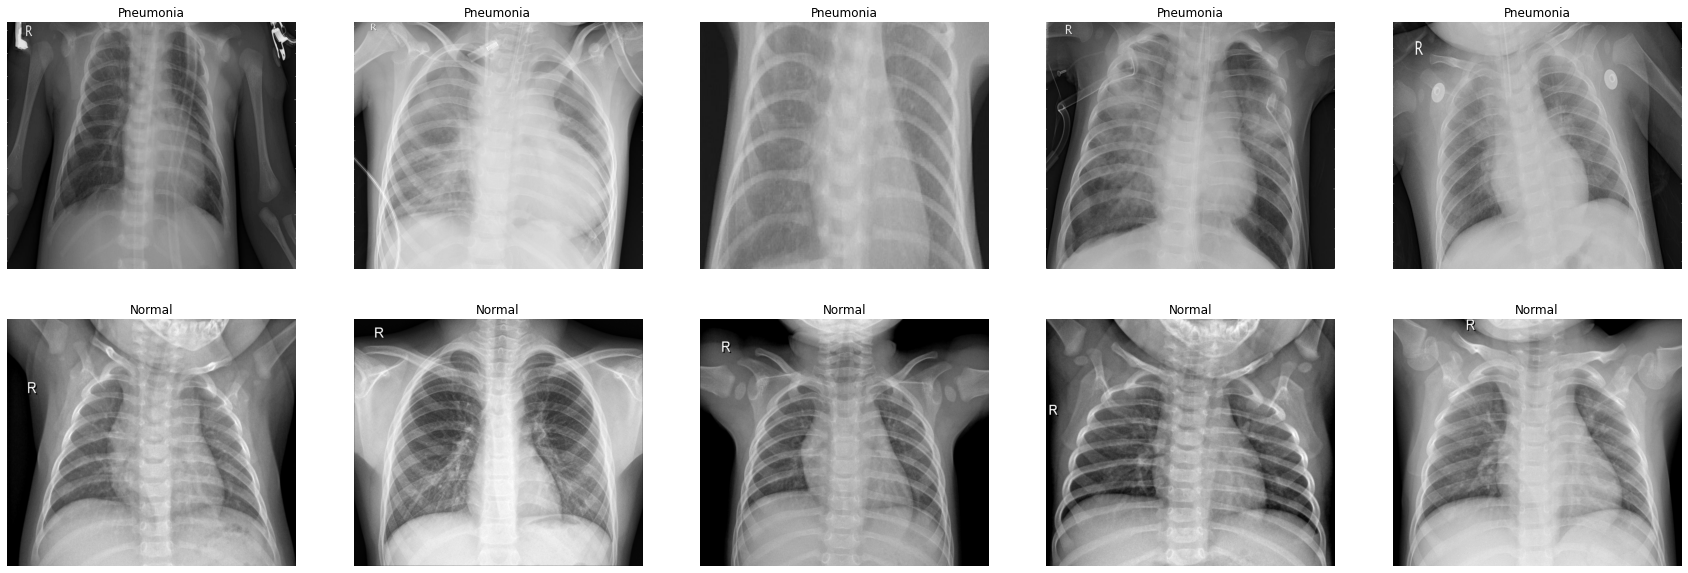

In [12]:
pneumonia_samples = (train_data[train_data['label']==1]['image'].iloc[:5]).tolist()
normal_samples = (train_data[train_data['label']==0]['image'].iloc[:5]).tolist()

samples = pneumonia_samples + normal_samples
del pneumonia_samples, normal_samples

f, ax = plt.subplots(2,5, figsize=(30,10))

for i in range(10):
    
    img = imread(samples[i])
    ax[i//5, i%5].imshow(img, cmap='gray')
    
    if i<5:
        ax[i//5, i%5].set_title("Pneumonia")
        
    else:
        ax[i//5, i%5].set_title("Normal")
        
    ax[i//5, i%5].axis('off')
    ax[i//5, i%5].set_aspect('auto')
    
plt.show()

In [5]:
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

In [6]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

x_train_bs = []
y_train_bs = []


# Deixando na dim 224 x 224

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224)).astype(np.float32)
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    label = to_categorical(0, num_classes = 2)
    x_train_bs.append(img)
    y_train_bs.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224)).astype(np.float32)
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    label = to_categorical(1, num_classes = 2)
    x_train_bs.append(img)
    y_train_bs.append(label)
    
x_train_bs = np.array(x_train_bs)
y_train_bs = np.array(y_train_bs)

In [7]:
x_train_bs.shape, y_train_bs.shape

((5216, 224, 224, 3), (5216, 2))

In [8]:
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

x_val_bs = []
y_val_bs = []

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224)).astype(np.float32)
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    label = to_categorical(0, num_classes = 2)
    x_val_bs.append(img)
    y_val_bs.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224)).astype(np.float32)
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    label = to_categorical(1, num_classes=2)
    x_val_bs.append(img)
    y_val_bs.append(label)
    
x_val_bs = np.array(x_val_bs)
y_val_bs = np.array(y_val_bs)

In [9]:
x_val_bs.shape, y_val_bs.shape

((16, 224, 224, 3), (16, 2))

In [29]:
'''
def history_precision_plot(history, title):
    plt.figure(figsize=(11,4))
    plt.subplot(1, 2, 1)
    plt.suptitle(title, fontsize=15)
    plt.xlabel("Número de Épocas")
    plt.ylabel('Loss', fontsize=12)
    plt.plot(history.history['loss'], color='r', label = 'Training-Loss')
    plt.plot(history.history['val_loss'], color='g', label = 'Val-Loss')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.xlabel("Número de Épocas")
    plt.ylabel('Precisão', fontsize=12)
    plt.plot(history.history['precision_1'], color='r', label='Training-prec')
    plt.plot(history.history['val_precision_1'], color='g', label='Val-prec')
    plt.legend(loc='best')
    plt.show()
'''

# Baseline Model

In [24]:
cnn_bs = tf.keras.models.Sequential()

cnn_bs.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))
cnn_bs.add(MaxPooling2D((2,2)))
cnn_bs.add(Flatten())
cnn_bs.add(Dense(units = 128, activation = 'relu'))
cnn_bs.add(Dense(units = 2, activation = 'sigmoid'))

In [25]:
cnn_bs.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = Precision())

hist_bs = cnn_bs.fit(x_train_bs, y_train_bs, epochs = 10, validation_data = (x_val_bs, y_val_bs))

Epoch 1/10
163/163 [==============================] - 104s 634ms/step - loss: 169.0028 - precision_3: 0.8836 - val_loss: 8.4974 - val_precision_3: 0.7333
Epoch 2/10
163/163 [==============================] - 103s 634ms/step - loss: 2.1244 - precision_3: 0.9586 - val_loss: 1.3424e-05 - val_precision_3: 1.0000
Epoch 3/10
163/163 [==============================] - 103s 630ms/step - loss: 0.8992 - precision_3: 0.9716 - val_loss: 4.4347 - val_precision_3: 0.8125
Epoch 4/10
163/163 [==============================] - 103s 632ms/step - loss: 1.0449 - precision_3: 0.9705 - val_loss: 16.5172 - val_precision_3: 0.6250
Epoch 5/10
163/163 [==============================] - 103s 632ms/step - loss: 0.1570 - precision_3: 0.9906 - val_loss: 2.6176 - val_precision_3: 0.9375
Epoch 6/10
163/163 [==============================] - 105s 643ms/step - loss: 0.0652 - precision_3: 0.9944 - val_loss: 1.8575 - val_precision_3: 0.9333
Epoch 7/10
163/163 [==============================] - 103s 633ms/step - loss: 0.6

In [26]:
cnn_bs.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 394272)            0         
                                                                 
 dense_4 (Dense)             (None, 128)               50466944  
                                                                 
 dense_5 (Dense)             (None, 2)                 258       
                                                                 
Total params: 50,468,098
Trainable params: 50,468,098
Non-trainable params: 0
__________________________________________

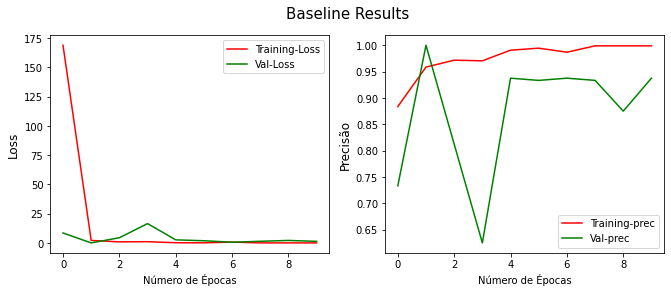

In [35]:
plt.figure(figsize=(11,4))
plt.subplot(1, 2, 1)
plt.suptitle("Baseline Results", fontsize=15)
plt.xlabel("Número de Épocas")
plt.ylabel('Loss', fontsize=12)
plt.plot(hist_bs.history['loss'], color='r', label = 'Training-Loss')
plt.plot(hist_bs.history['val_loss'], color='g', label = 'Val-Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.xlabel("Número de Épocas")
plt.ylabel('Precisão', fontsize=12)
plt.plot(hist_bs.history['precision_3'], color='r', label='Training-prec')
plt.plot(hist_bs.history['val_precision_3'], color='g', label='Val-prec')
plt.legend(loc='best')
plt.show()

# Training models

In [5]:
normal_cases_dir = train_dir / 'NORMAL'
pneumonia_cases_dir = train_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

x_train = []
y_train = []


# Deixando na escala de 3 canais (algumas estavam na escala de cinza, mas a maioria nao) e padronizando pelo max (255)

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes = 2)
    x_train.append(img)
    y_train.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] == 1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes = 2)
    x_train.append(img)
    y_train.append(label)

x_train = np.array(x_train)
y_train = np.array(y_train)

In [36]:
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

x_val = []
y_val = []

# Deixando na escala de 3 canais (algumas estavam na escala de cinza, mas a maioria nao) e padronizando pelo max (255)

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes = 2)
    x_val.append(img)
    y_val.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    x_val.append(img)
    y_val.append(label)
    
x_val = np.array(x_val)
y_val = np.array(y_val)

In [14]:
m1_ = tf.keras.models.Sequential()

m1_.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape=(224,224,3)))
m1_.add(MaxPooling2D(pool_size = 2, strides = 2))
m1_.add(Flatten())
m1_.add(Dense(units = 128, activation = 'relu'))
m1_.add(Dense(units = 2, activation = 'sigmoid'))

m1_.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = Precision())

hist_m_ = m1_.fit(
    x_train,
    y_train, 
    epochs = 10, 
    validation_data = (x_val, y_val)
)

Epoch 1/10
163/163 [==============================] - 113s 693ms/step - loss: 0.5061 - precision_1: 0.9099 - val_loss: 0.7230 - val_precision_1: 0.6875
Epoch 2/10
163/163 [==============================] - 111s 682ms/step - loss: 0.0699 - precision_1: 0.9746 - val_loss: 0.0769 - val_precision_1: 1.0000
Epoch 3/10
163/163 [==============================] - 110s 675ms/step - loss: 0.0405 - precision_1: 0.9883 - val_loss: 0.1137 - val_precision_1: 0.9375
Epoch 4/10
163/163 [==============================] - 114s 702ms/step - loss: 0.0244 - precision_1: 0.9935 - val_loss: 0.5290 - val_precision_1: 0.8125
Epoch 5/10
163/163 [==============================] - 109s 668ms/step - loss: 0.0126 - precision_1: 0.9971 - val_loss: 0.6209 - val_precision_1: 0.7222
Epoch 6/10
163/163 [==============================] - 111s 679ms/step - loss: 0.0060 - precision_1: 0.9998 - val_loss: 0.1484 - val_precision_1: 0.9375
Epoch 7/10
163/163 [==============================] - 115s 704ms/step - loss: 0.0022 - p

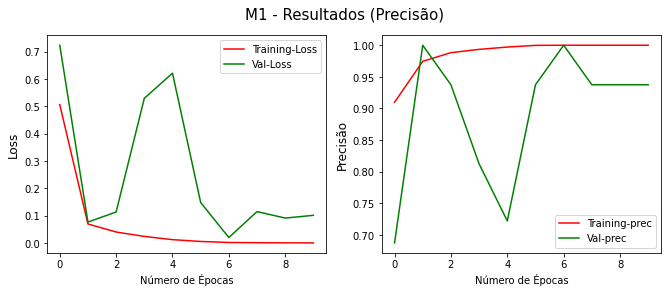

In [21]:
history_precision_plot(hist_m_, 'M1 - Resultados (Precisão)')

In [15]:
m2 = tf.keras.models.Sequential()

m2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(224,224,3)))
m2.add(MaxPooling2D((2,2)))
m2.add(Conv2D(64, (3,3), activation='relu'))
m2.add(MaxPooling2D((2,2)))
m2.add(Flatten())
m2.add(Dense(128, activation='relu'))
m2.add(Dense(2, activation='sigmoid'))

m2.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

hist_m2 = m2.fit(
    x_train,
    y_train, 
    epochs = 10, 
    validation_data = (x_val, y_val)
)

Epoch 1/10
163/163 [==============================] - 140s 852ms/step - loss: 0.2247 - accuracy: 0.9270 - val_loss: 0.2709 - val_accuracy: 0.9375
Epoch 2/10
163/163 [==============================] - 154s 945ms/step - loss: 0.0887 - accuracy: 0.9682 - val_loss: 0.3190 - val_accuracy: 0.8125
Epoch 3/10
163/163 [==============================] - 160s 981ms/step - loss: 0.0581 - accuracy: 0.9789 - val_loss: 0.6224 - val_accuracy: 0.8125
Epoch 4/10
163/163 [==============================] - 149s 915ms/step - loss: 0.0360 - accuracy: 0.9881 - val_loss: 0.4067 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 137s 843ms/step - loss: 0.0165 - accuracy: 0.9944 - val_loss: 0.7047 - val_accuracy: 0.8125
Epoch 6/10
163/163 [==============================] - 137s 843ms/step - loss: 0.0113 - accuracy: 0.9965 - val_loss: 0.3465 - val_accuracy: 0.8750
Epoch 7/10
163/163 [==============================] - 141s 865ms/step - loss: 0.0036 - accuracy: 0.9996 - val_loss: 0.7210 -

In [29]:
m2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

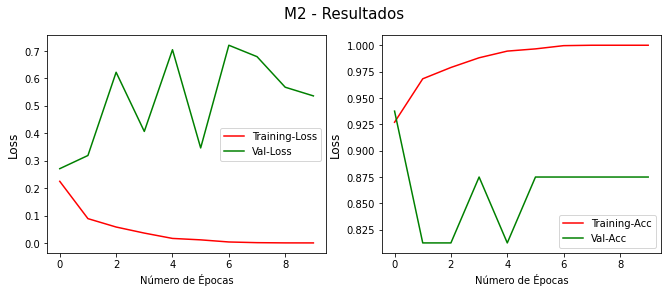

In [17]:
history_plot(hist_m2, 'M2 - Resultados')

### Data Augmentation

In [41]:
# Augmentation sequence 
seq = iaa.OneOf([
    iaa.Fliplr(), # horizontal flips
    iaa.Affine(rotate = 20), # roatation
    iaa.Multiply((1.2, 1.5))]) #random brightness

In [43]:
def data_gen_rgb(data, batch_size):
    
    n = len(data)
    steps = n//batch_size
    batch_data = np.zeros((batch_size, 224, 224, 3), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)
    indices = np.arange(n)
    
    # Initialize a counter
    i = 0
    
    while True:
        
        np.random.shuffle(indices)
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        
        for j, idx in enumerate(next_batch):
            
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # ohe
            encoded_label = to_categorical(label, num_classes=2)
            
            # read img 
            img = cv2.imread(str(img_name))
            img = cv2.resize(img, (224,224))
            
            # check if it's grayscale
            if img.shape[2] == 1:
                img = np.dstack([img, img, img])
            
            # cv2 reads in BGR mode by default
            orig_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # normalize max (255.)
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label==0 and count < batch_size-2:
                
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                
                aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB)
                aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
                
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [90]:
def data_gen_gray(data, batch_size):
    
    n = len(data)
    steps = n//batch_size
    batch_data = np.zeros((batch_size, 224, 224), dtype=np.float32)
    batch_labels = np.zeros((batch_size,2), dtype=np.float32)
    indices = np.arange(n)
    
    # Initialize a counter
    i = 0
    
    while True:
        
        np.random.shuffle(indices)
        count = 0
        next_batch = indices[(i*batch_size):(i+1)*batch_size]
        
        for j, idx in enumerate(next_batch):
            
            img_name = data.iloc[idx]['image']
            label = data.iloc[idx]['label']
            
            # ohe
            encoded_label = to_categorical(label, num_classes=2)
            
            # read img and convert to gray scale
            img = cv2.imread(str(img_name), cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (224,224))
            
            # normalize max (255.)
            orig_img = img.astype(np.float32)/255.
            
            batch_data[count] = orig_img
            batch_labels[count] = encoded_label
            
            # generating more samples of the undersampled class
            if label == 0 and count < batch_size-2:
                
                aug_img1 = seq.augment_image(img)
                aug_img2 = seq.augment_image(img)
                                
                aug_img1 = aug_img1.astype(np.float32)/255.
                aug_img2 = aug_img2.astype(np.float32)/255.

                batch_data[count+1] = aug_img1
                batch_labels[count+1] = encoded_label
                
                batch_data[count+2] = aug_img2
                batch_labels[count+2] = encoded_label
                
                count +=2
            
            else:
                count+=1
            
            if count==batch_size-1:
                break
            
        i+=1
        
        yield batch_data, batch_labels
            
        if i>=steps:
            i=0

In [91]:
normal_cases_dir = val_dir / 'NORMAL'
pneumonia_cases_dir = val_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

x_val_gray = []
y_val_gray = []

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224,224))
    
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes = 2)
    x_val_gray.append(img)
    y_val_gray.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224,224))

    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    x_val_gray.append(img)
    y_val_gray.append(label)
    
x_val_gray = np.array(x_val_gray)
y_val_gray = np.array(y_val_gray)

In [64]:
x_val_gray.shape, y_val_gray.shape

((16, 224, 224), (16, 2))

In [92]:
batch_size = 16

# Get a train data (gray scale and rgb) generator
train_data_gen_gray = data_gen_gray(data = train_data, batch_size = batch_size)
train_data_gen_rgb = data_gen_rgb(data = train_data, batch_size = batch_size)

# Define the number of training steps
nb_train_steps = train_data.shape[0]//batch_size

In [93]:
m1_gray = tf.keras.models.Sequential()

m1_gray.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape=(224,224, 1)))
m1_gray.add(Input(shape=(64, 64, 3)))
m1_gray.add(MaxPooling2D(pool_size = 2, strides = 2))
m1_gray.add(Flatten())
m1_gray.add(Dense(units = 128, activation = 'relu'))
m1_gray.add(Dense(units = 2, activation = 'sigmoid'))

m1_gray.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = Precision())

hist_m1_gray = m1_gray.fit(
    train_data_gen_gray, 
    epochs = 10, 
    steps_per_epoch = nb_train_steps,
    validation_data = (x_val_gray, y_val_gray)
)

Epoch 1/10
326/326 [==============================] - 153s 469ms/step - loss: 0.3678 - precision_12: 0.9126 - val_loss: 0.2859 - val_precision_12: 0.8667
Epoch 2/10
326/326 [==============================] - 151s 462ms/step - loss: 0.0693 - precision_12: 0.9762 - val_loss: 0.1461 - val_precision_12: 0.9375
Epoch 3/10
326/326 [==============================] - 148s 454ms/step - loss: 0.0609 - precision_12: 0.9791 - val_loss: 0.0371 - val_precision_12: 1.0000
Epoch 4/10
326/326 [==============================] - 150s 461ms/step - loss: 0.0423 - precision_12: 0.9864 - val_loss: 0.1975 - val_precision_12: 0.9375
Epoch 5/10
326/326 [==============================] - 144s 441ms/step - loss: 0.0289 - precision_12: 0.9912 - val_loss: 0.2166 - val_precision_12: 0.9375
Epoch 6/10
326/326 [==============================] - 144s 443ms/step - loss: 0.0243 - precision_12: 0.9925 - val_loss: 0.0557 - val_precision_12: 0.9375
Epoch 7/10
326/326 [==============================] - 144s 442ms/step - loss

In [99]:
hist_m1_gray.history.keys()

dict_keys(['loss', 'precision_12', 'val_loss', 'val_precision_12'])

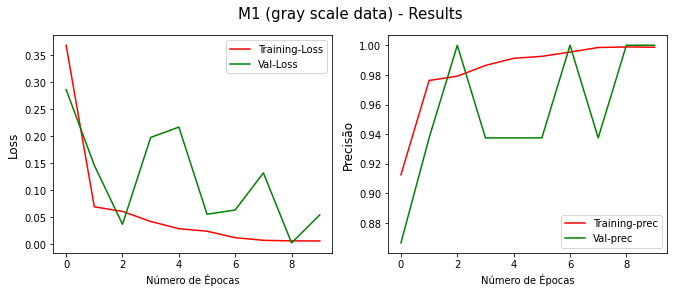

In [101]:
plt.figure(figsize=(11,4))
plt.subplot(1, 2, 1)
plt.suptitle("M1 (gray scale data) - Results", fontsize=15)
plt.xlabel("Número de Épocas")
plt.ylabel('Loss', fontsize=12)
plt.plot(hist_m1_gray.history['loss'], color='r', label = 'Training-Loss')
plt.plot(hist_m1_gray.history['val_loss'], color='g', label = 'Val-Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.xlabel("Número de Épocas")
plt.ylabel('Precisão', fontsize=12)
plt.plot(hist_m1_gray.history['precision_12'], color='r', label='Training-prec')
plt.plot(hist_m1_gray.history['val_precision_12'], color='g', label='Val-prec')
plt.legend(loc='best')
plt.show()

In [102]:
m1_rgb = tf.keras.models.Sequential()

m1_rgb.add(Conv2D(filters = 32, kernel_size = 3, activation = 'relu', input_shape=(224,224, 3)))
m1_rgb.add(Input(shape=(64, 64, 3)))
m1_rgb.add(MaxPooling2D(pool_size = 2, strides = 2))
m1_rgb.add(Flatten())
m1_rgb.add(Dense(units = 128, activation = 'relu'))
m1_rgb.add(Dense(units = 2, activation = 'sigmoid'))

m1_rgb.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = Precision())

hist_m1_rgb = m1_rgb.fit(
    train_data_gen_rgb, 
    epochs = 10, 
    steps_per_epoch = nb_train_steps,
    validation_data = (x_val, y_val)
)

Epoch 1/10
326/326 [==============================] - 161s 493ms/step - loss: 0.3853 - precision_13: 0.9138 - val_loss: 0.1718 - val_precision_13: 0.9375
Epoch 2/10
326/326 [==============================] - 157s 481ms/step - loss: 0.0734 - precision_13: 0.9748 - val_loss: 0.2488 - val_precision_13: 0.9286
Epoch 3/10
326/326 [==============================] - 159s 489ms/step - loss: 0.0517 - precision_13: 0.9803 - val_loss: 0.1608 - val_precision_13: 0.8750
Epoch 4/10
326/326 [==============================] - 154s 473ms/step - loss: 0.0323 - precision_13: 0.9894 - val_loss: 0.1066 - val_precision_13: 0.9375
Epoch 5/10
326/326 [==============================] - 152s 466ms/step - loss: 0.0240 - precision_13: 0.9921 - val_loss: 0.1646 - val_precision_13: 0.9375
Epoch 6/10
326/326 [==============================] - 152s 468ms/step - loss: 0.0150 - precision_13: 0.9950 - val_loss: 0.0740 - val_precision_13: 0.9375
Epoch 7/10
326/326 [==============================] - 153s 469ms/step - loss

In [103]:
hist_m1_rgb.history.keys()

dict_keys(['loss', 'precision_13', 'val_loss', 'val_precision_13'])

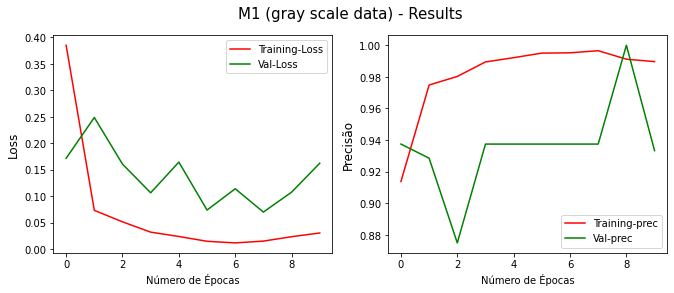

In [105]:
plt.figure(figsize=(11,4))
plt.subplot(1, 2, 1)
plt.suptitle("M1 (gray scale data) - Results", fontsize=15)
plt.xlabel("Número de Épocas")
plt.ylabel('Loss', fontsize=12)
plt.plot(hist_m1_rgb.history['loss'], color='r', label = 'Training-Loss')
plt.plot(hist_m1_rgb.history['val_loss'], color='g', label = 'Val-Loss')
plt.legend(loc='best')

plt.subplot(1, 2, 2)
plt.xlabel("Número de Épocas")
plt.ylabel('Precisão', fontsize=12)
plt.plot(hist_m1_rgb.history['precision_13'], color='r', label='Training-prec')
plt.plot(hist_m1_rgb.history['val_precision_13'], color='g', label='Val-prec')
plt.legend(loc='best')
plt.show()

# Test Dataset

In [106]:
normal_cases_dir = test_dir / 'NORMAL'
pneumonia_cases_dir = test_dir / 'PNEUMONIA'

normal_cases = normal_cases_dir.glob('*.jpeg')
pneumonia_cases = pneumonia_cases_dir.glob('*.jpeg')

x_test = []
y_test = []

# Normal cases
for img in normal_cases:
    img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224,224))
    
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes = 2)
    x_test.append(img)
    y_test.append(label)
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (224,224))

    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    x_test.append(img)
    y_test.append(label)
    
x_test = np.array(x_test)
y_test = np.array(y_test)

In [107]:
x_test.shape, y_test.shape

((624, 224, 224), (624, 2))

In [123]:
test_loss, test_score = m1_gray.evaluate(x_test, y_test)
print(f"Acurácia no conjunto de teste é {test_score:.2f}")

20/20 [==============================] - 2s 122ms/step - loss: 2.1543 - precision_12: 0.7260
Acurácia no conjunto de teste é 0.73


In [109]:
# Get predictions
preds = m1_gray.predict(x_test)
preds = np.argmax(preds, axis=-1)

# Original labels
test_labels = np.argmax(y_test, axis=-1)

print(orig_test_labels.shape)
print(preds.shape)

20/20 [==============================] - 3s 123ms/step
(624,)
(624,)


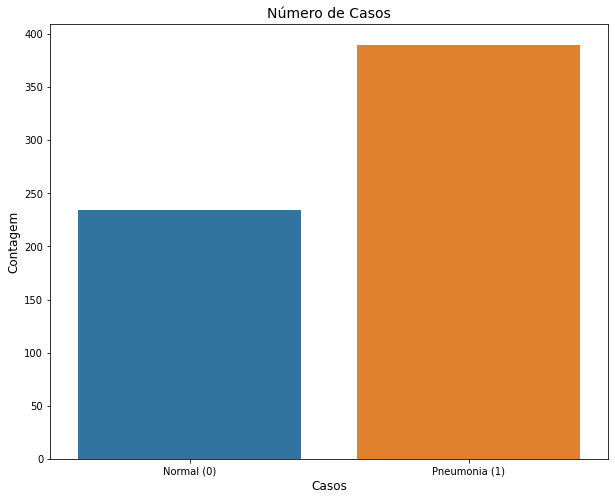

In [110]:
unique, counts = np.unique(test_labels, return_counts=True)
counts

plt.figure(figsize = (10,8))
sns.barplot(x = ['0', '1'], y = counts)
plt.title('Número de Casos', fontsize=14)
plt.xlabel('Casos', fontsize=12)
plt.ylabel('Contagem', fontsize=12)
plt.xticks(range(len(['0', '1'])), ['Normal (0)', 'Pneumonia (1)'])
plt.show()

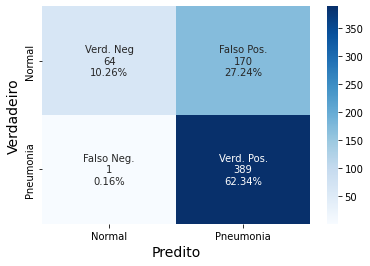

In [155]:
cm  = confusion_matrix(test_labels, preds)

group_names = ["Verd. Neg", "Falso Pos.","Falso Neg.", "Verd. Pos."]
group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
group_perc = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]

labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names, group_counts, group_perc)]
labels = np.asarray(labels).reshape(2,2)


cm_plot = sns.heatmap(
    cm, annot = labels, fmt = "", cmap = 'Blues', 
    xticklabels = ['Normal', 'Pneumonia'], 
    yticklabels = ['Normal', 'Pneumonia']
)
cm_plot.set_xlabel('Predito', fontsize = 14)
cm_plot.set_ylabel('Verdadeiro', fontsize = 14)
plt.show()

In [146]:
print(classification_report(preds, test_labels, target_names = ['Normal', 'Pneumonia'], digits = 3))

              precision    recall  f1-score   support

      Normal      0.274     0.985     0.428        65
   Pneumonia      0.997     0.696     0.820       559

    accuracy                          0.726       624
   macro avg      0.635     0.840     0.624       624
weighted avg      0.922     0.726     0.779       624



In [112]:
# Calculate Precision and Recall
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall do modelo é {:.3f}".format(recall))
print("Precisão do modelo é {:.3f}".format(precision))

Recall do modelo é 0.997
Precisão do modelo é 0.696
